# Importing modules

In [1]:
!pip install awkward vector 'weaver-core>=0.4' torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.4/879.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.7/342.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [2]:
# Since numpy's recent update was not very friendly to our weaver package, this is necessary (restart session after)
!pip install --upgrade --force-reinstall numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.1
    Uninstalling pytz-2025.1:
      Successfully uninstalled pytz-2025.1
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.1
    Uninstalling tzdata-2025.1:
      Successfully uninstalled tzdata-2025.1
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1

In [1]:
# After restarting session, continue with this cell
import gdown
import os
import pandas as pd
import numpy as np
import awkward as ak
import vector
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from weaver.nn.model.ParticleTransformer import ParticleTransformer
from weaver.utils.logger import _logger
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.ticker import MultipleLocator

# Utils

In [3]:
# Define functions needed to transform the input variables
def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})

def _transform(dataframe, start=0, stop=-1):

    df = dataframe.iloc[start:stop]

    def _col_list(prefix, max_particles=200):
        return ['%s_%d' % (prefix, i) for i in range(max_particles)]

    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values

    mask = _e > 0
    n_particles = np.sum(mask, axis=1)

    px = ak.unflatten(_px[mask], n_particles)
    py = ak.unflatten(_py[mask], n_particles)
    pz = ak.unflatten(_pz[mask], n_particles)
    energy = ak.unflatten(_e[mask], n_particles)

    p4 = _p4_from_pxpypze(px, py, pz, energy)

    jet_p4 = ak.sum(p4, axis=1)

    # outputs
    v = {}
    v['label'] = df['is_signal_new'].values

    v['jet_pt'] = jet_p4.pt
    v['jet_eta'] = jet_p4.eta
    v['jet_phi'] = jet_p4.phi
    v['jet_energy'] = jet_p4.energy
    v['jet_mass'] = jet_p4.mass
    v['jet_nparticles'] = n_particles

    v['part_px'] = px
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy

    _jet_etasign = ak.to_numpy(np.sign(v['jet_eta']))
    _jet_etasign[_jet_etasign == 0] = 1
    v['part_deta'] = (p4.eta - v['jet_eta']) * _jet_etasign
    v['part_dphi'] = p4.deltaphi(jet_p4)

    return v

# Padding function
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x

# Create input for the model
def build_features_and_labels(a, transform_features=True):
    # Compute new features
    a['part_mask'] = ak.ones_like(a['part_deta'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['jet_isTop'] = a['label']
    a['jet_isQCD'] = 1-a['label']

    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)
    label_list = ['jet_isTop', 'jet_isQCD']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)

    return out

# Define data configuration
class DataConfig:
    def __init__(self):
        self.input_dicts = {
            'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_deta',
            'part_dphi',
            ]
        }
        self.label_value = ['jet_isTop', 'jet_isQCD']
        self.input_names = ['pf_points', 'pf_features', 'pf_vectors', 'pf_mask']
        self.input_shapes = {
            'pf_points': (128, 2),
            'pf_features': (128, 7),
            'pf_vectors': (128, 4),
            'pf_mask': (128, 1)
        }

# Function to train model
def train_model(model, filename, train_loader, val_loader, optimizer, num_epochs, device='cuda'):

    model.to(device)
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0

        for points, features, lorentz_vectors, mask, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            points, features, lorentz_vectors, mask, labels = (
                points.to(device),
                features.to(device),
                lorentz_vectors.to(device),
                mask.to(device),
                labels.to(device),
            )

            optimizer.zero_grad()
            outputs = model(points, features, lorentz_vectors, mask)

            # Transform one-hote encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for points, features, lorentz_vectors, mask, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation'):
                points, features, lorentz_vectors, mask, labels = (
                    points.to(device),
                    features.to(device),
                    lorentz_vectors.to(device),
                    mask.to(device),
                    labels.to(device),
                )

                outputs = model(points, features, lorentz_vectors, mask)

                # Transform one-hote encoded labels to class indices
                labels = torch.argmax(labels, dim=1)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("Training complete.")
    torch.save(model.state_dict(), filename)
    model.load_state_dict(torch.load(filename))
    return model, history

# Plot training history
def plot_training_history(history):

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, history["train_loss"], label="Train Loss")
    ax1.plot(epochs, history["val_loss"], label="Val Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.set_title("Training & Validation Loss")
    ax1.xaxis.set_major_locator(MultipleLocator(2))

    # Accuracy plot
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, history["train_acc"], label="Train Acc")
    ax2.plot(epochs, history["val_acc"], label="Val Acc")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.set_title("Training & Validation Accuracy")
    ax2.xaxis.set_major_locator(MultipleLocator(2))

    plt.tight_layout()
    plt.show()

# Evaluate model on test set
def evaluate_model(model, dataloader, device='cuda'):

    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    model.eval()
    model.to(device)
    test_loss, correct, total = 0, 0, 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for points, features, lorentz_vectors, mask, labels in dataloader:
            points, features, lorentz_vectors, mask, labels = (
                points.to(device),
                features.to(device),
                lorentz_vectors.to(device),
                mask.to(device),
                labels.to(device),
            )

            outputs = model(points, features, lorentz_vectors, mask)

            # Transform one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            # Transform logits to probabilities
            probs = softmax(outputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_acc = correct / total
    print(f"Test Acc: {test_acc:.4f}")
    test_loss /= len(dataloader)
    print(f"Test Loss: {test_loss:.4f}")

    return np.concatenate(all_probs, axis=0), np.concatenate(all_labels, axis=0)

# Plotting ROC curves and determining rjection rate
def plot_roc_curves_vs_background(y_true, y_probs, class_labels, background_class_label, tpr_target1=0.5, tpr_target2=0.3, figsize=(8, 6)):
    background_idx = class_labels.index(background_class_label)
    plt.figure(figsize=figsize)

    for i, class_label in enumerate(class_labels):
        if class_label == background_class_label:
            continue  # Skip background

        # Mask for signal and background only
        mask = (np.array(y_true) == i) | (np.array(y_true) == background_idx)
        y_true_bin = np.array([1 if y == i else 0 for y in y_true])[mask]
        y_score = y_probs[:, i][mask]

        # ROC
        fpr, tpr, _ = roc_curve(y_true_bin, y_score)
        auc = roc_auc_score(y_true_bin, y_score)

        # Rejection point 1
        idx1 = np.argmin(np.abs(tpr - tpr_target1))
        fpr_at_target1 = fpr[idx1]
        tpr_at_target1 = tpr[idx1]
        rej1 = 1 / fpr_at_target1 if fpr_at_target1 > 0 else float("inf")

        # Rejection point 2
        idx2 = np.argmin(np.abs(tpr - tpr_target2))
        fpr_at_target2 = fpr[idx2]
        tpr_at_target2 = tpr[idx2]
        rej2 = 1 / fpr_at_target2 if fpr_at_target2 > 0 else float("inf")

        label = f"{class_label} (AUC={auc:.4f})"
        plt.plot(fpr, tpr, label=label)
        plt.plot(fpr_at_target1, tpr_at_target1, "o", markersize=5, label = f"Rejection rate at {int(tpr_target1*100)}% TPR: {rej1:.0f}")
        plt.plot(fpr_at_target2, tpr_at_target2, "o", markersize=5, label = f"Rejection rate at {int(tpr_target2*100)}% TPR: {rej2:.0f}")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curves: Signal vs. Background")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Just for reference -> calculate AUC using paper method (only relevant for multi-class)
    # Convert y_true to a PyTorch tensor
    y_true = torch.tensor(y_true)
    # One-hot encode the labels
    y_true_onehot = torch.nn.functional.one_hot(y_true, num_classes=len(class_labels))
    auc_paper = roc_auc_score(y_true_onehot, y_probs, average='macro', multi_class='ovo')
    print(f"AUC using paper method: {auc_paper:.4f}")

# ParticleNet Model Functions

In [4]:
# Model ParticleNet Fine-tune
from weaver.nn.model.ParticleNet import ParticleNet

class ParticleNetWrapper(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()

        in_dim = kwargs['fc_params'][-1][0]
        num_classes = kwargs['num_classes']
        self.for_inference = kwargs['for_inference']

        # finetune the last FC layer
        self.fc_out = nn.Linear(in_dim, num_classes)

        kwargs['for_inference'] = False
        self.mod = ParticleNet(**kwargs)
        self.mod.fc = self.mod.fc[:-1]

    def forward(self, points, features, lorentz_vectors, mask):
        x_cls = self.mod(points, features, mask)
        output = self.fc_out(x_cls)
        if self.for_inference:
            output = torch.softmax(output, dim=1)
        return output


def get_model(data_config, **kwargs):
    conv_params = [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
    ]
    fc_params = [(256, 0.1)]

    pf_features_dims = len(data_config.input_dicts['pf_features'])
    num_classes = len(data_config.label_value)
    model = ParticleNetWrapper(
        input_dims=pf_features_dims,
        num_classes=num_classes,
        conv_params=kwargs.get('conv_params', conv_params),
        fc_params=kwargs.get('fc_params', fc_params),
        use_fusion=kwargs.get('use_fusion', False),
        use_fts_bn=kwargs.get('use_fts_bn', True),
        use_counts=kwargs.get('use_counts', True),
        for_inference=kwargs.get('for_inference', False)
    )

    model_info = {
        'input_names': list(data_config.input_names),
        'input_shapes': {k: ((1,) + s[1:]) for k, s in data_config.input_shapes.items()},
        'output_names': ['softmax'],
        'dynamic_axes': {**{k: {0: 'N', 2: 'n_' + k.split('_')[0]} for k in data_config.input_names}, **{'softmax': {0: 'N'}}},
    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

# Preprocessing data

In [5]:
# Download data from drive

# Training data - https://drive.google.com/file/d/1-CLSkZV-rFvmh1drhyyjTi98h8NhHr8F/view?usp=sharing
file_id = '1-CLSkZV-rFvmh1drhyyjTi98h8NhHr8F'
gdown.download(f'https://drive.google.com/uc?id={file_id}', quiet=False)

# Validation data - https://drive.google.com/file/d/1-2y3CwIK8KRMG-Q1hZBWYcGK1uvcJcRG/view?usp=sharing
file_id = '1-2y3CwIK8KRMG-Q1hZBWYcGK1uvcJcRG'
gdown.download(f'https://drive.google.com/uc?id={file_id}', quiet=False)

# Test data - https://drive.google.com/file/d/1-3hZcKxl40KzCMDWPGb0SOBlpmwqh17B/view?usp=sharing
file_id = '1-3hZcKxl40KzCMDWPGb0SOBlpmwqh17B'
gdown.download(f'https://drive.google.com/uc?id={file_id}', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-CLSkZV-rFvmh1drhyyjTi98h8NhHr8F
To: /content/TopLandscape_train_12k.csv
100%|██████████| 53.8M/53.8M [00:00<00:00, 96.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2y3CwIK8KRMG-Q1hZBWYcGK1uvcJcRG
To: /content/TopLandscape_val_4k.csv
100%|██████████| 17.9M/17.9M [00:00<00:00, 160MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3hZcKxl40KzCMDWPGb0SOBlpmwqh17B
To: /content/TopLandscape_test_4k.csv
100%|██████████| 17.9M/17.9M [00:00<00:00, 182MB/s]


'TopLandscape_test_4k.csv'

In [6]:
# Processing datasets
# Get data to variables
data_train = pd.read_csv("/content/TopLandscape_train_12k.csv")
data_val = pd.read_csv("/content/TopLandscape_val_4k.csv")
data_test = pd.read_csv("/content/TopLandscape_test_4k.csv")

# Transformed datasets
v_train = _transform(data_train)
v_val = _transform(data_val)
v_test = _transform(data_test)

# Transform dictionary to awkward array
train_input = ak.Array(v_train)
val_input = ak.Array(v_val)
test_input = ak.Array(v_test)

# Final processing step to create inputs
train_inputs = build_features_and_labels(train_input)
val_inputs = build_features_and_labels(val_input)
test_inputs = build_features_and_labels(test_input)

# Create loaders
# Training data
train_dataset = TensorDataset(
    torch.tensor(train_inputs['pf_points'], dtype=torch.float32),
    torch.tensor(train_inputs['pf_features'], dtype=torch.float32),
    torch.tensor(train_inputs['pf_vectors'], dtype=torch.float32),
    torch.tensor(train_inputs['pf_mask'], dtype=torch.float32),
    torch.tensor(train_inputs['label'], dtype=torch.long)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation data
val_dataset = TensorDataset(
    torch.tensor(val_inputs['pf_points'], dtype=torch.float32),
    torch.tensor(val_inputs['pf_features'], dtype=torch.float32),
    torch.tensor(val_inputs['pf_vectors'], dtype=torch.float32),
    torch.tensor(val_inputs['pf_mask'], dtype=torch.float32),
    torch.tensor(val_inputs['label'], dtype=torch.long)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Testing data
test_dataset = TensorDataset(
    torch.tensor(test_inputs['pf_points'], dtype=torch.float32),
    torch.tensor(test_inputs['pf_features'], dtype=torch.float32),
    torch.tensor(test_inputs['pf_vectors'], dtype=torch.float32),
    torch.tensor(test_inputs['pf_mask'], dtype=torch.float32),
    torch.tensor(test_inputs['label'], dtype=torch.long)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defining classes

In [7]:
class_labels = ['t', 'q/g']
backgroundclass = 'q/g'

# Training ParticleNet

In [8]:
# Data configuration
data_config = DataConfig()
model, model_info = get_model(data_config)

In [ ]:
# Set model parameters
num_epochs = 8
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

# Train model
model, history = train_model(model, "best_model.pth", train_loader, val_loader, optimizer, num_epochs, device='cuda')

Epoch 1/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.23it/s]


Epoch 1/8: Train Loss: 0.3195, Train Acc: 0.8700, Val Loss: 0.2899, Val Acc: 0.8852


Epoch 2/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.62it/s]


Epoch 2/8: Train Loss: 0.2588, Train Acc: 0.8958, Val Loss: 0.2331, Val Acc: 0.9060


Epoch 3/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.85it/s]


Epoch 3/8: Train Loss: 0.2419, Train Acc: 0.8984, Val Loss: 0.2270, Val Acc: 0.9055


Epoch 4/8 Validation: 100%|██████████| 125/125 [00:03<00:00, 40.93it/s]


Epoch 4/8: Train Loss: 0.2305, Train Acc: 0.9041, Val Loss: 0.2327, Val Acc: 0.9050


Epoch 5/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.91it/s]


Epoch 5/8: Train Loss: 0.2180, Train Acc: 0.9102, Val Loss: 0.2212, Val Acc: 0.9080


Epoch 6/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.30it/s]


Epoch 6/8: Train Loss: 0.2138, Train Acc: 0.9120, Val Loss: 0.2211, Val Acc: 0.9105


Epoch 7/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.91it/s]


Epoch 7/8: Train Loss: 0.2079, Train Acc: 0.9131, Val Loss: 0.2296, Val Acc: 0.9062


Epoch 8/8 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.91it/s]

Epoch 8/8: Train Loss: 0.2037, Train Acc: 0.9178, Val Loss: 0.2163, Val Acc: 0.9135
Training complete.


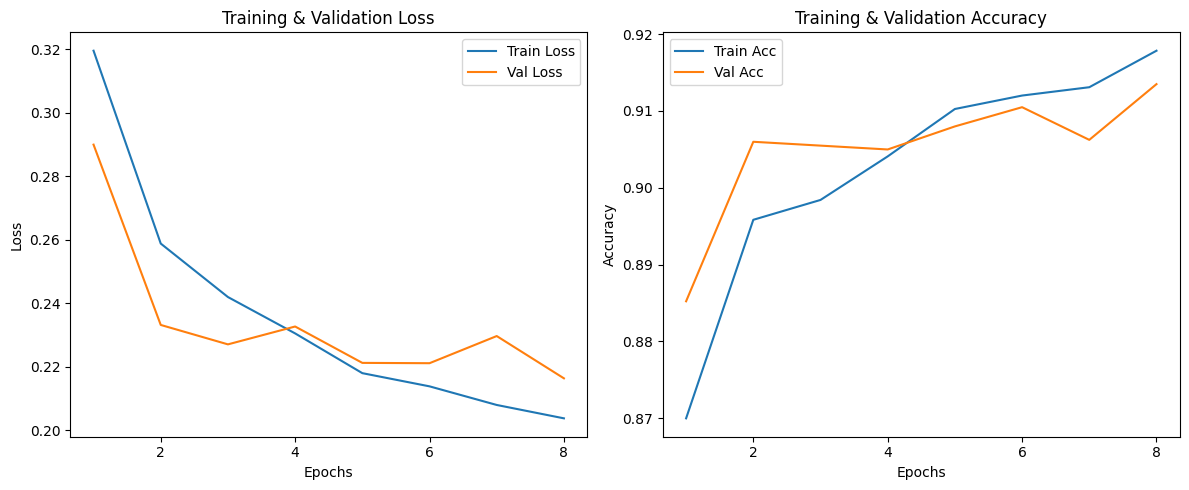

In [ ]:
# Plot training history
plot_training_history(history)

In [9]:
print(summary(model, input_names=model_info['input_names'], input_shapes=model_info['input_shapes']))

Layer (type:depth-idx)                        Param #
ParticleNetWrapper                            --
├─Linear: 1-1                                 514
├─ParticleNet: 1-2                            --
│    └─BatchNorm1d: 2-1                       14
│    └─ModuleList: 2-2                        --
│    │    └─EdgeConvBlock: 3-1                10,048
│    │    └─EdgeConvBlock: 3-2                58,368
│    │    └─EdgeConvBlock: 3-3                231,424
│    └─Sequential: 2-3                        --
│    │    └─Sequential: 3-4                   65,792
Total params: 366,160
Trainable params: 366,160
Non-trainable params: 0


The weights of the final training used for evaluation of the model's performance can be found on our Github. This is implemented below:

In [10]:
# Get weights from Github
!wget https://raw.githubusercontent.com/ijkeja/DLfinalproject/main/TopLandscape/finalmodels/TOP_ParticleNet_model.pth -O TOP_ParticleNet_model.pth

# Get model and load weights
data_config = DataConfig()
model, model_info = get_model(data_config)
model.load_state_dict(torch.load('TOP_ParticleNet_model.pth'))

--2025-03-25 12:10:02--  https://raw.githubusercontent.com/ijkeja/DLfinalproject/main/TopLandscape/finalmodels/TOP_ParticleNet_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1507490 (1.4M) [application/octet-stream]
Saving to: ‘TOP_ParticleNet_model.pth’

TOP_ParticleNet_mod 100%[===================>]   1.44M  --.-KB/s    in 0.02s   

2025-03-25 12:10:02 (65.2 MB/s) - ‘TOP_ParticleNet_model.pth’ saved [1507490/1507490]



<All keys matched successfully>

Test Acc: 0.9137
Test Loss: 0.2196


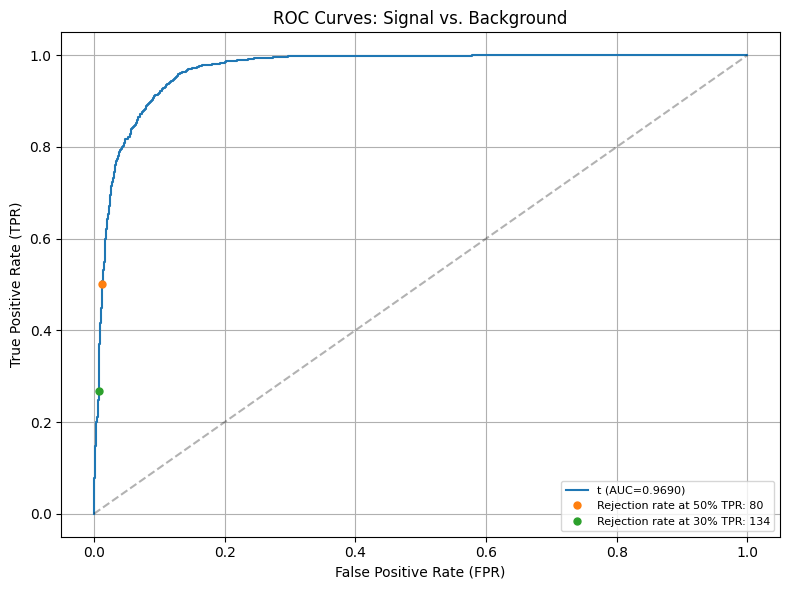

AUC using paper method: 0.9690


In [11]:
y_probs, y_true = evaluate_model(model, test_loader)
plot_roc_curves_vs_background(y_true, y_probs, class_labels, backgroundclass, tpr_target1=0.5, tpr_target2=0.3)

# Training ParticleNet-f.t.

In [12]:
# Check performance of model with pre-trained weights (from training on full JetClass dataset)
# Import pre-trained weights from particle_transformer GitHub

!wget https://raw.githubusercontent.com/jet-universe/particle_transformer/main/models/ParticleNet_kin.pt -O pretrained_weights.pth

--2025-03-25 12:13:22--  https://raw.githubusercontent.com/jet-universe/particle_transformer/main/models/ParticleNet_kin.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514546 (1.4M) [application/octet-stream]
Saving to: ‘pretrained_weights.pth’

pretrained_weights. 100%[===================>]   1.44M  --.-KB/s    in 0.02s   

2025-03-25 12:13:23 (60.0 MB/s) - ‘pretrained_weights.pth’ saved [1514546/1514546]



In [13]:
# Define model
dataconfig = DataConfig()
pretrained_model, pretrained_model_info = get_model(dataconfig)

# Load the pre-trained dict
pretrained_dict = torch.load('pretrained_weights.pth', map_location=torch.device('cuda:0'))
pretrained_model_dict = pretrained_model.state_dict()

# Filter out weights for layers that don't match
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in pretrained_model_dict and pretrained_model_dict[k].shape == v.shape}
loaded_keys = set(filtered_dict.keys())
missing_keys = set(pretrained_model_dict.keys()) - loaded_keys
print(f"Missing keys: {missing_keys}")

# Update model dict
pretrained_model_dict.update(filtered_dict)
pretrained_model.load_state_dict(pretrained_model_dict, strict=False)

Missing keys: {'fc_out.weight', 'fc_out.bias'}


<All keys matched successfully>

In [ ]:
# Different learning rates for pre-trained parameters and new parameters
# Seperate parameters by whether they were loaded or not
pretrained_params = []
new_params = []

for name, param in pretrained_model.named_parameters():
    if name in loaded_keys:
        pretrained_params.append(param)
    else:
        new_params.append(param)

# Set model parameters
num_epochs = 10
lr = 1e-4
weightdecay = 0.01
# optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=lr)
optimizer = torch.optim.AdamW([
    {'params': pretrained_params, 'lr': 1e-4},
    {'params': new_params, 'lr': 1e-3}
])

# Train model
pretrained_model, pretrained_history = train_model(pretrained_model, "best_pretrained_model.pth", train_loader, val_loader, optimizer, num_epochs, device='cuda')

Missing keys: {'fc_out.bias', 'fc_out.weight'}


Epoch 1/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.78it/s]


Epoch 1/10: Train Loss: 0.2908, Train Acc: 0.9081, Val Loss: 0.1821, Val Acc: 0.9257


Epoch 2/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.32it/s]


Epoch 2/10: Train Loss: 0.1809, Train Acc: 0.9274, Val Loss: 0.1697, Val Acc: 0.9310


Epoch 3/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.62it/s]


Epoch 3/10: Train Loss: 0.1730, Train Acc: 0.9317, Val Loss: 0.1672, Val Acc: 0.9335


Epoch 4/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.64it/s]


Epoch 4/10: Train Loss: 0.1681, Train Acc: 0.9344, Val Loss: 0.1644, Val Acc: 0.9352


Epoch 5/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.37it/s]


Epoch 5/10: Train Loss: 0.1631, Train Acc: 0.9369, Val Loss: 0.1646, Val Acc: 0.9340


Epoch 6/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.41it/s]


Epoch 6/10: Train Loss: 0.1631, Train Acc: 0.9367, Val Loss: 0.1631, Val Acc: 0.9347


Epoch 7/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.61it/s]


Epoch 7/10: Train Loss: 0.1590, Train Acc: 0.9379, Val Loss: 0.1621, Val Acc: 0.9350


Epoch 8/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.95it/s]


Epoch 8/10: Train Loss: 0.1576, Train Acc: 0.9392, Val Loss: 0.1614, Val Acc: 0.9357


Epoch 9/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 48.96it/s]


Epoch 9/10: Train Loss: 0.1566, Train Acc: 0.9387, Val Loss: 0.1610, Val Acc: 0.9360


Epoch 10/10 Validation: 100%|██████████| 125/125 [00:02<00:00, 49.38it/s]

Epoch 10/10: Train Loss: 0.1567, Train Acc: 0.9396, Val Loss: 0.1616, Val Acc: 0.9365
Training complete.


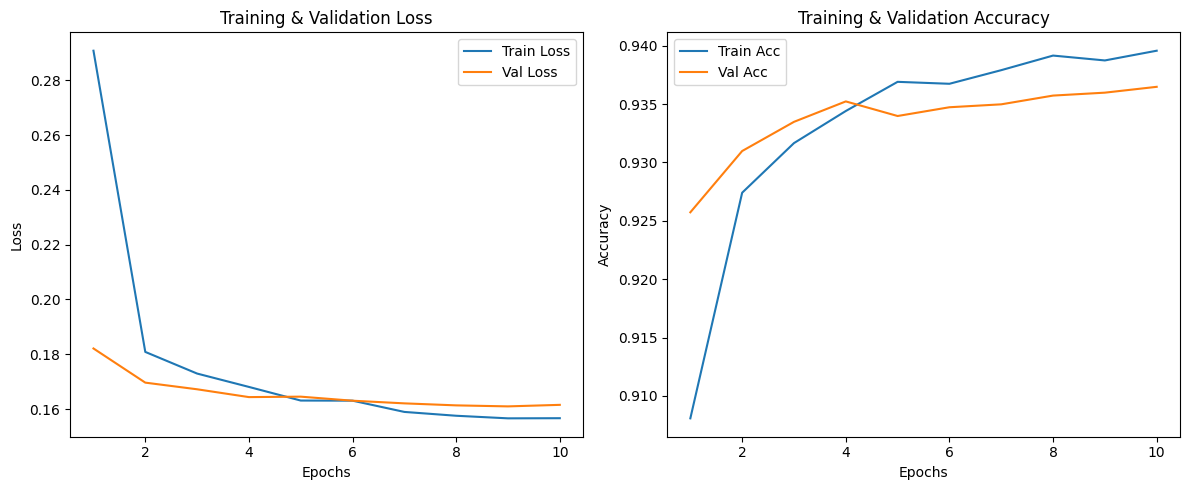

In [ ]:
# Plot training history
plot_training_history(pretrained_history)

The weights of the final training used for evaluation of the model's performance can be found on our Github. This is implemented below:

In [14]:
# Get weights from Github
!wget https://raw.githubusercontent.com/ijkeja/DLfinalproject/main/TopLandscape/finalmodels/TOP_ParticleNetft_model.pth -O TOP_ParticleNetft_model.pth

# Get model and load weights
data_config = DataConfig()
pretrained_model, pretrained_model_info = get_model(data_config)
pretrained_model.load_state_dict(torch.load('TOP_ParticleNetft_model.pth'))

--2025-03-25 12:15:54--  https://raw.githubusercontent.com/ijkeja/DLfinalproject/main/TopLandscape/finalmodels/TOP_ParticleNetft_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1508425 (1.4M) [application/octet-stream]
Saving to: ‘TOP_ParticleNetft_model.pth’

TOP_ParticleNetft_m 100%[===================>]   1.44M  --.-KB/s    in 0.02s   

2025-03-25 12:15:54 (62.1 MB/s) - ‘TOP_ParticleNetft_model.pth’ saved [1508425/1508425]



<All keys matched successfully>

Test Acc: 0.9302
Test Loss: 0.1736


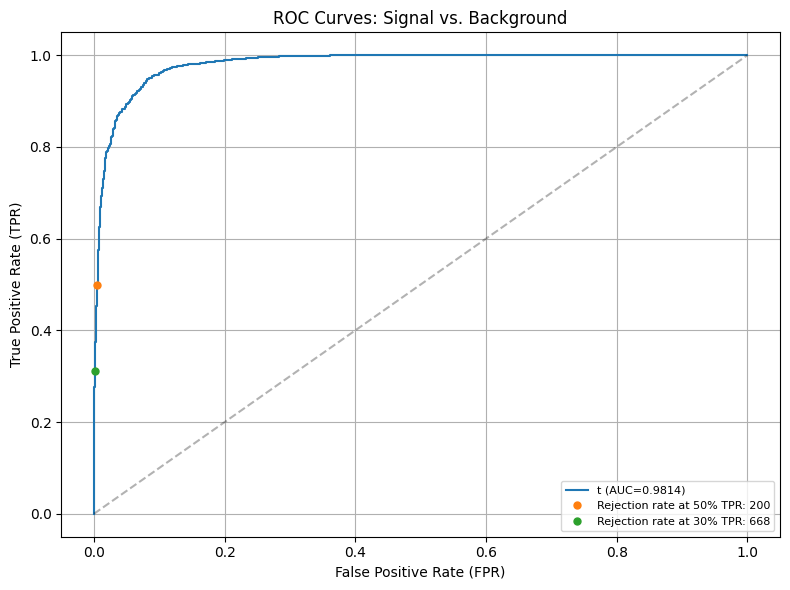

AUC using paper method: 0.9814


In [15]:
y_probs, y_true = evaluate_model(pretrained_model, test_loader)
plot_roc_curves_vs_background(y_true, y_probs, class_labels, backgroundclass, tpr_target1=0.5, tpr_target2=0.3)